# Overview of the document

This file contains the code needed to create, fit, and analyze the data of a category learning experiment.



#### Hierarchical Bayesian model

The data will be analyzed with a Bayesian hierarchical model coded with PyMC3, a Python implementation of Hamiltonian Monte Carlo algorithms and related tools for Bayesian statistics. The response variable is the number of times the participant judged that the presented stimulus belongs to the category. The predictor variables are the condition, the stimuli presented as belonging to the category that the participant should infer, and how many times the participant is asked to categorize the stimuli.

There are three levels in the hierarchical model. The bottom level encodes how many times a specific participant judged a specific stimulus as belonging or not to the category. The middle level clusters the single judgments into participants. The top level encodes information about clusters of participants. 

At the bottom level, the participants’ judgments for the stimuli are distributed Binomially, and they are coded as the number of times the participant judged that the presented stimulus belongs to the category. The Binomial $n$ parameter is the number of times that the participant was asked to categorize that stimulus. The $p$ parameter for stimulus $i$ and participant $j$ is the sum of the probabilities that $j$ attributes to all the categories that contain $i$ (*hypothesis averaging* from Xu & Tenenbaum, 2007), plus an error applied that is estimated for $j$. The categories are the convex set of stimuli, i.e. any set of stimuli such that if two stimuli $s$ and $p$ belong to the set, then any stimulus $q$ between $s$ and $p$ also belongs to the set.

The posterior probability over categories for each participant is calculated at the second level of the hierarchical model. For agent $j$, it is a function of three things: which stimuli are presented to $j$ as belonging to the category, $j$’s prior preference for monotonic categories, and $j$’s prior preference for categories of certain sizes. The posterior of $j$ for a category $k$ is proportional to the product of the likelihood, i.e. the probability of the presented stimuli $v$ given $k$, and the probability that $j$ attributes a priori to $k$. The probability $p(v | k)$ is calculated following the size principle discussed in Xu & Tenenbaum (2007) (see the full specification of the model below).

The population level parameters are the following. (1) Population level distribution(s) of preferences for monotonic hypotheses. This is two distributions, one per condition. (2) A population level distribution of preference for large or small hypotheses. Same for both conditions. (3) A population level distribution of production error. Same for both conditions. 

The hyperpriors can be read below from the full description of the model.

Full model:

\begin{align}
\textrm{ACCEPT}_{i, j} & \sim \textrm{Binomial}(\omega_{j, i}, \phi_{j, i}) \\
\\
\phi_{j, i} & = g(\textrm{PE}_j, \sum_{h \in \mathbb{H}}p_j(h) \mathbb{1}_{i \in h})\\
p_j(h) & = p(h | \textrm{PL}_j, \textrm{PM}_j, \textrm{OBS}_j) \quad \textrm{for } h \in \mathbb{H}\\
p(h | \textrm{PL}_j, \textrm{PM}_j, \textrm{OBS}_j) & \propto p(\textrm{OBS}_j | h, \textrm{PL}_j, \textrm{PM}_j) p(h | \textrm{PM}_j, \textrm{PL}_j) = p(\textrm{OBS}_j | h) p(h | \textrm{PM}_j, \textrm{PL}_j)  \\
p(\textrm{OBS}_j | h) & = \mathbb{1}_{\textrm{OBS}_j \subseteq h}\frac{1}{|h|^{|\textrm{OBS}_j|}} \\
p(h | \textrm{PM}_j, \textrm{PL}_j) & \propto p(h | \textrm{PM}_j) p(h | \textrm{PL}_j) \\
p(h | \textrm{PM}_j) & = \textrm{PM}_{j} \mathbb{1}_{\textrm{mon}}(k) + (1 – \textrm{PM}_{j})(1 – \mathbb{1}_{\textrm{mon}}(k)) \\
p(h | \textrm{PL}_j) & = e^{|h| \textrm{PL}_j} \\
\\
\textrm{PL}_j & \sim \mu_{\textrm{PL}} + \sigma_{\textrm{PL}} \textrm{Normal}(0, 1) \\
\textrm{logit}(\textrm{PM}_j) & \sim \mu_{\textrm{PM, CONDITION}_j} + \sigma_{\textrm{PM, CONDITION}_j} \textrm{Normal}(0, 1)\\
\textrm{PE}_j & \sim \textrm{HalfNormal}(\sigma_{\textrm{PE}})\\
\\
\mu_{\textrm{PL}} & \sim \textrm{Normal}(0, 2) \\
\sigma_{\textrm{PL}} & \sim \textrm{HalfNormal}(2) \\
\mu_{\textrm{PM, CONDITION}_j} & \sim \textrm{Normal}(0, 2) \\
\sigma_{\textrm{PM, CONDITION}_j} & \sim \textrm{HalfNormal}(1) \\
\sigma_{\textrm{PE}} & \sim \Gamma(1, 2)\\
\end{align}

Where 
- $\textrm{ACCEPT}_{i, j}$ is the number of times participant $j$ accepted stimulus $i$ as belonging to the category.
- $\omega_{j, i}$ is the number of times participant $j$ was asked to categorize stimulus $i$.
- $\phi_{j, i}$ is the probability of participant $j$ accepting stimulus $i$.
- $\mathbb{H}$ is the set of convex hypotheses.
- $h$ is used ambiguously as a set of stimuli, e.g. in $i\in h$, and the event that the hypothesis to infer is the set $h$, e.g. $p(h)$. Context should disambiguate how each instance is meant.
- $\mathbb{1}_{i \in h}$ is the indicator function for whether hypothesis $h$ contains stimulus $i$.
- $g(x, y) = y + (\frac{1}{1 + e^{-x}}-0.5)(1-2y)$. For all values of $y$, $g(x, y) \to 0.5$ as $x\to\inf$ and $g(x, y) = y$ if $x=0$. We use this function to model the error in $j$'s production behaviour. As the error $\to \inf$, the choice of whether to accept or not a stimulus becomes uncorrelated with the participant's biases.
- $\textrm{PE}_j$ is $j$'s production error.
- $\textrm{PL}_j$ is $j$'s preference for large hypotheses.
- $\textrm{PM}_j$ is $j$'s preference for monotonic hypotheses.
- $\textrm{OBS}_j$ is the set of stimuli that were presented to $j$ as belonging to the category.
- $\textrm{CONDITION}_j$ is the condition of participant $j$, coded as 0 (for distance condition) or 1 (for property condition).
- We parameterize the $\Gamma$ distribution with $\alpha$ and $\beta$.

The simpler model assumes that the participant's preferences for monotonicity are sampled from a single distribution, rather than difference distributions for the two conditions.

#### Hypothesis testing

Call $x^{s}$ the value of model variable $x$ at the $s^{th}$ posterior sample, out of $S$ samples. We calculate the posterior distribution of differences between the means of the population-level distribution over preferences for monotonicity between two conditions $ \{ \mu^{s}_{\textrm{PM}, \textrm{CONDITION}_0} - \mu^{s}_{\textrm{PM}, \textrm{CONDITION}_1} \}_{i=1}^S$. We calculate the 95\% HPD interval, and we accept the hypothesis that there is a difference between the two conditions with respect to the preference for monotonic hypotheses iff the HPD interval does not contain 0.

#### Practicalities

This document contains the code to fit the model to the experimental data and analyze the results. Fitting the model is computationally intensive, and the LOO CV requires numerous fits. Therefore, we add code to run the model on the server. The code is written for Oracle Grid Engine (https://en.wikipedia.org/wiki/Oracle_Grid_Engine), but other implementations can be written based on the code below.

#### References

Xu, Fei, and Joshua B. Tenenbaum. 2007. “Word Learning as Bayesian Inference.” Psychological Review 114 (2): 245–72. https://doi.org/10.1037/0033-295X.114.2.245.

# Model

In [5]:
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import seaborn
import itertools as it
from pprint import pprint
from glob import glob
import os
import pickle
import copy

In [2]:
import theano 
import theano.tensor as tt

PyMC3 has to be imported after theano, otherwise an error is raised when trying to define theano functions

In [3]:
import pymc3 as pm

Keep track of the versions:

In [4]:
for lib in [np, sp, pd, theano, pm]:
    print(lib.__name__, lib.__version__)

numpy 1.15.4
scipy 1.1.0
pandas 0.23.4
theano 1.0.3
pymc3 3.5


# Various useful functions

In [213]:
def lognormalize(array):
    """
    Parameters
    ----------
    array: array
        an array with unnormalized logprobabilities
    
    Returns
    -------
    array
        array lognormalized (i.e. np.sum(np.exp(return_array)) == 1 )
    """
    return np.subtract(array, sp.special.logsumexp(array))


def make_hypotheses(num):
    # create an array with shape (index start hypothesis, index end hypothesis INCLUSIVE)
    hypotheses = [[x, y] 
                for x in range(num) 
                for y in range(num)
                # <= because, since endpoint is inclusive, if they are the same it's a one point category
                if x <= y]
    return np.array(hypotheses)


def mask_monotone(hypotheses):
    smallest = 0
    greatest = np.max(hypotheses[:, 1])
    return (hypotheses[:, 0] == 0) |(hypotheses[:, 1] == greatest)


def hypothesis_stim_compatible(hypotheses):
    num_stims = np.max(hypotheses) + 1 
    starts_array = np.tile(hypotheses[:,0], reps=(num_stims, 1))
    ends_array = np.tile(hypotheses[:,1], reps=(num_stims, 1))
    stims_array = np.tile(np.arange(num_stims).reshape(-1, 1), reps=(1, len(hypotheses)))
    compatibility_mask = (stims_array >= starts_array) & (stims_array <= ends_array)
    return compatibility_mask


def mask_hypoths_contains_observed(hypoths, observed):
    """
    Parameters
    ----------
    hypoths: array
        containing hypotheses. Shape (# hypotheses, 2). First column is the start of the hypotheses and 
        second column is end (inclusive)
    observed: array
        array of shape (# participants, # stims)
    Return
    ------
    array
        an array with shape (# participants, # hypotheses) saying for each hypothesis whether
        all the observations of the participant were contained in the hypothesis
    """
    flipped = np.flip(observed, axis=1)
    cumsum = np.cumsum(flipped, axis=1)
    argmax = np.argmax(cumsum, axis=1)
    min_seen = observed.shape[1] - argmax - 1
    min_seen_stacked = np.tile(min_seen.reshape(-1,1), reps=(1, len(hypoths)))
    
    cumsum_obs = np.cumsum(observed, axis=1)
    max_seen = np.argmax(cumsum_obs, axis=1)
    max_seen_stacked = np.tile(max_seen.reshape(-1, 1), reps=(1, len(hypoths)))
    
    hypoths_starts_stacked = np.tile(hypoths[:,0], reps=(len(observed), 1))
    hypoths_ends_stacked = np.tile(hypoths[:,1], reps=(len(observed), 1))
    
    fully_contained_mask = ((min_seen_stacked >= hypoths_starts_stacked) 
                            & (max_seen_stacked <= hypoths_ends_stacked))
    
    return fully_contained_mask

    
def get_hypotheses_info(shown_stimuli, hypotheses, num_participants):
    """
    Parameters
    ----------
    shown_stimuli: boolean array
        boolean array with shape (# participants, # stims) that says for each stim whether it
        was shown to the participant as belonging to the category.
    hypotheses: 2d array
        Array with shape (# hypotheses, (hypothesis start, hypothesis end))
    num_participants: int
        Number of participants
    
    Returns
    -------
    dict
        Various information about the hypotheses.
    """
    
    ############ various calculated as function of input

    # the number of stimuli observed as categorized by participant
    # make sure it has shape (# participants, 1)
    num_observed_stims = np.sum(shown_stimuli, axis=1, keepdims=True)

    # compatibility between each stim and each hypothesis.
    # Shape: (# participants, # stims, # hypotheses)
    # a tiled version of a matrix (# stims, # hypotheses)
    compatibility = hypothesis_stim_compatible(hypotheses)
    compatibility = np.tile(compatibility, reps=(num_participants, 1, 1))

    # row array with shape (# hypotheses)
    hypoths_sizes = hypotheses[:,1] - hypotheses[:,0] + 1

    # boolean matrix saying whether each hypothesis contains all the stimuli observed by each participant
    # array with shape (# participants, # hypotheses)
    hypoths_contains_all_observed = mask_hypoths_contains_observed(hypotheses, shown_stimuli)

    # array that says which hypotheses are monotone
    # shape= (1, # hypotheses)
    monotone_hypoths = mask_monotone(hypotheses)
    
    return num_observed_stims, compatibility, hypoths_sizes, hypoths_contains_all_observed, monotone_hypoths


def plot_sample_prior_preference(mon_pref_hyper_mu_mu, mon_pref_hyper_mu_sd, mon_pref_hyper_sd_sd, 
                                 num_samples_hyper=100):
    """
    Plots multiple prior distributions over monotonicity preferences sampled from the hyperprior distribution
    with the given parameters.
    
    Parameters
    ----------
    mon_pref_hyper_mu_mu: int
        Mean of Normal distribution over means of the population-level distribution over preferences 
        for monotonicity. Keep it at 0, i.e. 0.5 mean of the population level dist of preferences for monotonicity.
    mon_pref_hyper_mu_sd: int
        same as mon_pref_hyper_mu_mu for sd.
        Determines the variation in the position of the mean of the population level distribution around
        the hyperprior mean.
    mon_pref_hyper_sd_sd: int
        standard deviation of HalfNormal distribution describing the sd of Normal distributions
        describing population-level distribution over monotonicity preferences.
        Regulates the spread of the population-level distribution.
    num_samples_hyper: int
        Number of population-level distributions over monotonicity sampled from the given parameters
    
    Returns
    -------
    None
    """
    xs = np.linspace(0.001, 1, 1000, endpoint=False).reshape(-1,1)
    # bring the xs in the -inf, inf interval
    xs_logit = sp.special.logit(xs)

    # sample from a Normal with mean mon_pref_hyper_mu_mu and standard deviation mon_pref_hyper_mu_sd
    # these are samples for the (transformed) mean of the population level distributions 
    # for monotonicity preferences
    mus = np.random.normal(
        loc=mon_pref_hyper_mu_mu, scale=mon_pref_hyper_mu_sd, size=num_samples_hyper
    )

    # transform the Normal with mean mon_pref_hyper_mu_mu and standard deviation mon_pref_hyper_mu_sd 
    # with inverse logit
    # this is the real distribution of means of the population distribution for monotonicity preferences
    real_pop_means = sp.special.expit(mus)
    
    # sample from a halfNormal with sd mon_pref_hyper_sd_sd
    # these are samples for the (transformed) precision of the popoulation-level monotonicity 
    # preference distribution
    sds = sp.stats.halfnorm.rvs(scale=mon_pref_hyper_sd_sd, size=num_samples_hyper)
    
    # create a bunch of normal distributions with the means and standard deviations sampled above
    normals = sp.stats.norm(loc=mus, scale=sds)
    
    # create the sampled normal distributions and apply inverse logit to bring them in the [0,1] interval
    # These normal distributions are the population level distributions sampled from the specified hyperpriors
    logit_samples = normals.pdf(xs_logit).T
    
    samples = sp.special.expit(logit_samples)
    
    # plot the sampled distribution
    for distribution_data in samples:
        plt.plot(xs, distribution_data)
        
    plt.show()

In [314]:
def display_error(production_error):
    prob_accept_without_error = np.linspace(0, 1, 100)
    z = (1 / (1 + np.exp(-production_error))) - 0.5
    prob_accept = z+prob_accept_without_error*(1-2*z)
    plt.plot(prob_accept_without_error, prob_accept)
    plt.ylim(0, 1)
    plt.xlabel("Prob without error")
    plt.ylabel("Prob with error")

def hyperprior_error(size=100):
    """
    This function shows the production error level from the hyperprior.
    """
    # a is the alpha parameter, scale is the inverse of the beta parameter
    sampled_prod_error_sds = sp.stats.gamma.rvs(a=1, scale=1/2, size=size)
    prod_error = sp.stats.halfnorm.rvs(scale=sampled_prod_error_sds)
    for prod_err in prod_error:
        display_error(prod_err)
    plt.show()

In [311]:
def plot_mon_hyperprior():
    """
    Samples from the hyperprior to check if the parameters are realistic
    """
    
    with pm.Model() as model:

        mon_pref_hyper_mu = pm.Normal(name="mon_pref_hyper_mu", mu=0, sd=1.5)
        mon_pref_hyper_sd = pm.HalfNormal(name="mon_pref_hyper_sd", sd=1)
        z_scores_noncentered = pm.Normal(name="z_scores_mon_noncentered", mu=0, sd=1)

        # non-centered parameterization
        monotonicity_preferences_logit = pm.Deterministic(
            "mon_pref_logit",
            mon_pref_hyper_mu + mon_pref_hyper_sd * z_scores_noncentered
        )

        # values of the preference for monotonicity for each agent
        # inherits the shape of z_scores_uncentered, so shape (# participants, 1)
        monotonicity_preferences = pm.Deterministic(
            "mon_pref_participants", 
            pm.math.invlogit(monotonicity_preferences_logit))
        
        trace = pm.sample(draws=10000)
    pm.traceplot(trace)

#### Hyperprior over population-level distributions

These are samples from the hyperprior of the population-wide distribution over preferences for monotonicity. The prior is compatible with a large variety of population-level distribution for monotonicity. Some of them are very wide, some are very narrow, and they appear both at the center and at the borders.

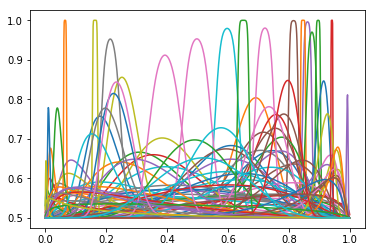

In [211]:
plot_sample_prior_preference(0, 2, 1)

An error of 0.5 disturbs the judgments somewhat.
An error of 4 already has a big impact.

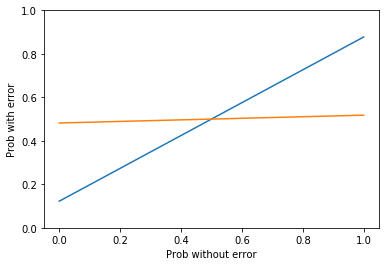

In [315]:
display_error(0.5)
display_error(4)

Sampling errors from the hyperprior shows that most of the errors are small, with the possibility of getting some extreme errors.

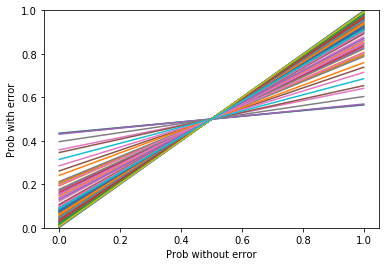

In [316]:
hyperprior_error()

Sampling monotonicity levels from the hyperprior shows that the model is a priori quite neutral about the preference for monotonicity.

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [z_scores_mon_noncentered, mon_pref_hyper_sd, mon_pref_hyper_mu]
Sampling 2 chains: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 21000/21000 [00:30<00:00, 689.98draws/s]
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There were 25 divergences after tuning. Increase `target_accept` or reparameterize.
C:\Users\pplsuser\Anaconda3\envs\pymc3_statistical_rethinking\lib\site-packages\matplotlib\axes\_base.py:3604: MatplotlibDeprecationWarning: 
The `ymin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `bottom` instead.
  alternative='`bottom`', obj_type='argument')
C:\Users\pplsuser\Anaconda3\envs\pymc3_statistical_rethinking\lib\site-packages\matplotlib\axes\_base.py:3604: MatplotlibDeprecationWarning: 
The `ymin` argument was deprecated in Matplotlib 3.0 an

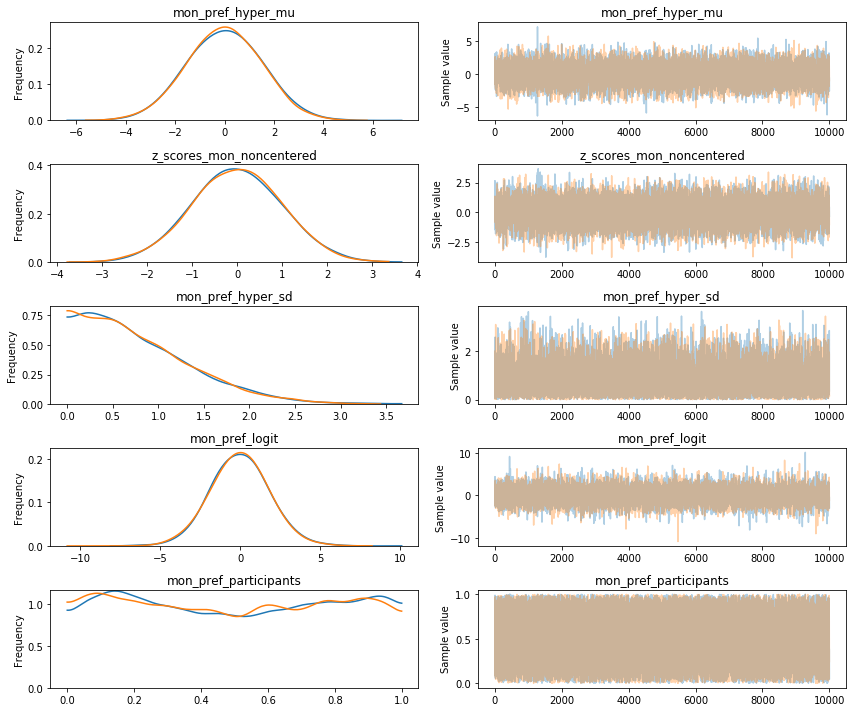

In [313]:
plot_mon_hyperprior()

### PyMC3 diagnostic functions

In [215]:
def available_names(trace):
    available = pm.artists.get_trace_dict(trace, pm.utils.get_default_varnames(trace.varnames, True)).keys()
    return list(available)

In [216]:
def plot_leapfrog(trace_to_study, model_to_study, var0, var1, index_0=None, index_1=None):
    """
    Parameters
    ----------
    trace_to_study: pymc3 Trace object
        The trace to analyze
    model_to_study: pymc3 Model 
        The model to analyze
    var_0, var_1: strings
        the names of the two variables the pairplot of which should be plotted
    index_0, index_1: int
        the indices to be plotted if the vars contain more than one value
        (None by default if a var is not multidimensional)
    
    Returns
    -------
    None
    """
    # based on: https://docs.pymc.io/notebooks/Diagnosing_biased_Inference_with_Divergences.html
    
    from collections import defaultdict
    
    assert var0 in trace_to_study.varnames, "var0, {}, is not in the trace".format(var0)
    assert var1 in trace_to_study.varnames, "var1, {}, is not in the trace".format(var1)

    divergent_point = defaultdict(list)

    chain_warn = trace_to_study.report._chain_warnings
    # loops over chains (e.g. 4 chains)
    for i in range(len(chain_warn)):
        # loop over the divergences in each chain
        for warning_ in chain_warn[i]:
            # check that the relevant information is actually there 
            # (e.g. that there were divergences at all)
            if warning_.step is not None and warning_.extra is not None:
                # go through the variables and save what values they have
                for RV in model_to_study.free_RVs:
                    para_name = RV.name
                    divergent_point[para_name].append(warning_.extra[para_name])

    # transform the saved info into arrays                
    for RV in model_to_study.free_RVs:
        para_name = RV.name
        divergent_point[para_name] = np.asarray(divergent_point[para_name])
            
    var0_d = divergent_point[var0][:,index_0] if index_0 != None else divergent_point[var0]
    var1_d = divergent_point[var1][:,index_1] if index_1 != None else divergent_point[var1]
    Ndiv_recorded = len(var0)
    
    # if index_i is a "falsy" value, to_add becomes "" and the original name is used
    # otherwise, index_i is added
    to_add_0 = "_" + str(index_0) if index_0 != None else ""
    to_add_1 = "_" + str(index_1) if index_1 != None else ""
    
    print(var0 + to_add_0, var1 + to_add_1)
    
    pm.pairplot(
        trace_to_study,
        sub_varnames=[
            var0 + to_add_0, 
            var1 + to_add_1
        ],
        divergences=True,
        color='C7', 
        alpha=0.2, 
        figsize=(5, 5),
        kwargs_divergence={'color':'C2', 'label':'Divergent samples'})

    plt.scatter(
        var0_d, 
        var1_d,
        color='C3', 
        alpha=.5, 
        label='Location of Energy error (start location of leapfrog)'
    )

    plt.title('Scatter plot between the variables')
    plt.legend()
    plt.show()

In [217]:
def plot_leapfrog_for_all_vars(trace1, model1, index_for_multidimensional=0):
    """
    Parameters
    ----------
    trace1: pymc3 Trace object
        The trace to analyze
    model1: pymc3 Model object
        The model to analyze
    index_for_multidimensional: int
        if there is a multidimensional variable, which index to plot
    
    Returns
    -------
    None
    """
    # I have to transform them into strings because they are free variable objects
    names = [str(i) for i in list(model1.free_RVs)]

    for var0, var1 in (
            (var0, var1) 
            for var0 in names 
            for var1 in names 
            if (var0 != var1)):
        # check if the variable needs an index
        index_0 = index_for_multidimensional if (var0 not in available_names(trace1)) else None
        index_1 = index_for_multidimensional if (var1 not in available_names(trace1)) else None
        print(var0, var1, index_0, index_1)
        plot_leapfrog(trace1, model1, var0, var1, index_0, index_1)
        

### Function for plotting participants

In [259]:
def plot_raw_data(simulated_data, real_params, display_vlines=False):
    """
    Parameters
    ----------
    simulated_data, real_params: dicts
        Dicts returned by the produce_simulated_data function
    display_vlines: bool
        Whether to display the vertical lines where the probability of accepting intersects 0.5
        
    Returns
    -------
    None
    """
    
    shown_stims = simulated_data["shown_stimuli"] 
    conditions = simulated_data["conditions"] 
    asked = simulated_data["asked_stimuli"] 
    responses = simulated_data["responses"]
    hypoths_sizes = simulated_data["hypoths_sizes"]
    pref_large = real_params["pref_large"]
    num_observed_stims = simulated_data["num_observed_stims"]
    hypoths_contains_all_observed = simulated_data["hypoths_contains_all_observed"]
    compatibility = simulated_data["compatibility"]
    num_stims = responses.shape[1]
    prod_error = real_params["prod_error"]
    monotone_hypoths = simulated_data["monotone_hypoths"]
    
    posterior_probs_sampled = calculate_acceptance_prob_matrix(
        # the real parameters
        monotonicity_preferences=real_params["pref_mon_participants"], 
        production_error=prod_error, 
        pref_large=pref_large, 
        
        # also independent of the participants
        # this is the same for all participants and independent of how many participants there are
        monotone_hypoths=monotone_hypoths, 
        hypoths_sizes=hypoths_sizes, 
        num_observed_stims=num_observed_stims, 
        hypoths_contains_all_observed=hypoths_contains_all_observed,
        compatibility=compatibility,
        num_stims=num_stims
    )
    
    # loop over participants
    for i in range(len(shown_stims)):
        
        plt.plot(posterior_probs_sampled[i])
        plt.hlines(y=0.5, xmin=0, xmax=num_stims)
        
        if display_vlines:
            intersections = np.argwhere(np.diff(np.sign(0.5 - posterior_probs_sampled[i])))
            for inter_x in intersections:
                plt.vlines(x=inter_x+0.5, ymin=0, ymax=1)
        
        # the indices of the stims that the participant was asked about
        asked_indices = np.where(responses[i,:] >= 0)[0]
        
        # how many times each stimulus was accepted 
        num_accepted = responses[i, asked_indices]
        
        # how many times the stimulus was asked about
        num_asked = asked[i, asked_indices]
        
        # plot the numbers
        for index, num_accept, num_ask in zip(asked_indices, num_accepted, num_asked):
            plt.text(x=index, y=0.04, s=str(int(num_ask)))
            plt.text(x=index, y=0.1, s=str(int(num_accept)))

        # plot shown stimuli
        shown_indices = np.where(shown_stims[i,:])[0]
        plt.scatter(shown_indices, [0.2]*len(shown_indices), color="b")
        plt.ylim(0, 1)
        plt.xlim(0, 36)
        plt.show()
        

In [219]:
def plot_participants(shown_stims, conditions, asked, responses, trace):
    """
    Plots a bunch of information for each participant from the data and the fitted model.
    
    Parameters
    ----------
    shown_stims: numpy array
        binary array of shape (# participants, # stims) that is 1 if the stim was shown as categorized
    responses: numpy array
        array of shape (# participants, # stims). 
        # of times the participant accepted out the times it was asked. -1 if never asked.
    conditions: numpy array
        array of shape (# participants, 1) that specifies the condition of each participant
    asked: int array
        Array with the number of times that each participant was asked to categorize each stim
    trace: pymc3 Trace object
        trace object producted by PyMC3
    
    Return
    ------
    None
    """
    
    # number of samples to draw from the trace for each participant
    num_samples = 1000
        
    # loop over participants and plot the information for each participant
    x = np.arange(shown_stims.shape[1])
    
    # loop over participants
    for i in range(len(shown_stims)):
        ######## the data #########
        # create tiled data specific to participant i
        try:
            # implement if prob_accept was saved in the trace
            # samples of the acceptance probabilities for agent i
            posterior_probs_sampled = trace["prob_accept"][np.random.randint(
                low=0, high=len(trace["prob_accept"]), size=num_samples),i,:]

        except KeyError:
            mon_prefs_sampled = np.random.choice(
                trace["mon_pref_participants"][:,i,:].flatten(), size=num_samples).reshape(-1,1)
            pref_large_sampled = np.random.choice(
                trace["pref_large"][:,i,:].flatten(), size=num_samples).reshape(-1,1)
            prod_error_sampled = np.random.choice(
                trace["prod_error"][:,i,:].flatten(), size=num_samples).reshape(-1,1)
            num_observed_stims_stacked = np.tile(
                exp_params["num_observed_stims"][i], reps=(num_samples,1))
            hypoths_contains_all_observed_sampled = np.tile(
                exp_params["hypoths_contains_all_observed"][i,:], reps=(num_samples,1))
            compatibility_sampled = np.tile(
                exp_params["compatibility"][i,:,:], reps=(num_samples, 1, 1))

            # calculate a bunch of probs of accepting a stim given the expected values of the posterior parameters
            # for participant i
            posterior_probs_sampled = calculate_acceptance_prob_matrix(
                monotonicity_preferences=mon_prefs_sampled, 
                # this is the same for all participants and independent of how many participants there are
                monotone_hypoths=exp_params["monotone_hypoths"], 
                # also independent of the participants
                hypoths_sizes=exp_params["hypoths_sizes"], 
                pref_large=pref_large_sampled, 
                num_observed_stims=num_observed_stims_stacked, 
                hypoths_contains_all_observed=hypoths_contains_all_observed_sampled,
                production_error=prod_error_sampled, 
                compatibility=compatibility_sampled,
                num_stims=36
            )
        
        
        ######### plot the data ##########
        
        fig, (judg_ax, prod_error_ax, mon_pref_ax, pref_large_ax) = plt.subplots(1, 4, figsize=(18, 4))
        
        # plot the probabilities

        # the xs for the plot function (which are the column indices) represent the indices of the stimuli
        _, xs = np.indices(posterior_probs_sampled.shape)
        xs = xs.reshape(-1, 1)
        # the values are the probabilities sampled from the posterior of agent i accepting the stim
        ys = posterior_probs_sampled.reshape(-1,1)
        df = pd.DataFrame(np.column_stack((xs, ys)), columns=["xs", "ys"])
        seaborn.lineplot(x="xs", y="ys", data=df, ax=judg_ax, err_style='band', ci=99)

        # the indices of the stims that the participant was asked about
        asked_indices = np.where(responses[i,:] >= 0)[0]
        # how many times each stimulus was accepted 
        num_accepted = responses[i, asked_indices]
        # how many times the stimulus was asked about
        num_asked = asked[i, asked_indices]
        # plot the numbers
        for index, num_accept, num_ask in zip(asked_indices, num_accepted, num_asked):
            judg_ax.text(x=index, y=0.04, s=str(int(num_ask)))
            judg_ax.text(x=index, y=0.1, s=str(int(num_accept)))
        
        # plot shown stimuli
        shown_indices = np.where(shown_stims[i,:])[0]
        judg_ax.scatter(shown_indices, [0.2 for _ in shown_indices], color="b")
        judg_ax.set_ylim(0, 1)
        judg_ax.set_title("Posterior stim acceptance")
        
        seaborn.distplot(trace["prod_error"][:,i], norm_hist=True, ax=prod_error_ax)
        # This xlims is for the old model with error over hypotheses
#         prod_error_ax.set_xlim(0, 0.005)
        # This xlims is for the new model
        prod_error_ax.set_xlim(0, 3)
        prod_error_ax.set_title("Posterior prod error")
        
        seaborn.distplot(trace["mon_pref_participants"][:,i], norm_hist=True, ax=mon_pref_ax) 
        mon_pref_ax.set_xlim(0, 1)
        mon_pref_ax.set_title("Posterior mon pref")
        
        seaborn.distplot(trace["pref_large"][:,i], ax=pref_large_ax)
        pref_large_ax.set_xlim(-4, 4)
        pref_large_ax.set_title("Posterior pref large hypoths")
        
        fig.suptitle(str(i) + ("Property" if conditions[i] else "Distance"))

        plt.show()

### Functions to produce simulated data

In [220]:
def calculate_acceptance_prob_matrix(monotonicity_preferences, monotone_hypoths, hypoths_sizes, 
        pref_large, num_observed_stims, hypoths_contains_all_observed,
        production_error, compatibility, num_stims):
    """
    Function to calculate the posterior probability of each participant over stimuli
    given their parameters and the stimuli they observed as categorized.
    
    Parameters
    ----------
    monotonicity_preferences: array
        Array with shape (# participants, 1) containing the preference for monotonicity for each participant
    monotone_hypoths: array
        A boolean array containing the mask of the monotone hypotheses out of all hypotheses
    hypoths_sizes: array
        An int array containing the sizes of each hypothesis
    pref_large: array
        An array containing the preference for large hypothesis for each participant
    num_observed_stims: array
        An int array containing the number of stimuli observed as categorized by each participant
    hypoths_contains_all_observed: array
        A boolean array describing for each combination of participant and hypothesis whether
        the hypothesis contains all of the categorized stimuli observed by the participant
    production_error: array
        An array describing the production error for each participant
    compatibility: array
        An array describing for each hypothesis which stimuli are compatible with it, 
        tiled for num_participants
    num_stims: int
        The number of stimuli
    
    Returns
    -------
    array
        The posterior probability that each participant will accept each stimulus, given the stims 
        they observed as categorized.        
    """


    def log_sum_exp(x, axis=None):
        """
        Numpy version
        """
        x_max = np.max(x, axis=axis, keepdims=True)
        return np.log(np.sum(np.exp(x - x_max), axis=axis, keepdims=True)) + x_max

    def lognormalize_rows(unnorm_logprob):
        # normalize the rows of unnorm_logprob
        # unnorm_logprob has shape e.g. (# participants, # hypotheses)
        normalization_factor = np.repeat(
            log_sum_exp(unnorm_logprob, axis=1), 
            unnorm_logprob.shape[1], 
            axis=1)
        logprob = unnorm_logprob - normalization_factor
        return logprob

    num_hypotheses = len(monotone_hypoths)
    num_participants = len(monotonicity_preferences)

    monotonicity_preferences_stacked = monotonicity_preferences.repeat(repeats=num_hypotheses, axis=1)

    # logprior_mon contains the (unnorm) prior probability of each hypothesis based on preference for monotonicity
    # shape = (# participants, # hypotheses)
    logprior_mon = np.log(np.where(
        monotone_hypoths, 
        monotonicity_preferences_stacked, 
        1-monotonicity_preferences_stacked
    ))

    # hypoths_sizes is a row array with len (hypotheses), while the logprior has shape (# participants, # hypotheses)

    # so I need to tile hypoths_sizes and pref_large
    # TODO: understand broadcastable dimensions in theano better
    hypoths_sizes_stacked = np.tile(hypoths_sizes, (num_participants, 1))
    pref_large_stacked = np.tile(pref_large, (1, num_hypotheses))

    # logprior_size contains the (unnorm) prior probability of each hypothesis 
    # based on preference for large categories
    # it is a softmax function, so an exponential. The log(exp(sizes * pref_large)) simplifies
    logprior_size = hypoths_sizes_stacked * pref_large_stacked

    logprior = logprior_mon + logprior_size

    ##### likelihood #######
    # TODO: pre-calculate it instead of here


    # shape = (# participants, # hypotheses)
    unmasked_logliks = (
        -num_observed_stims.repeat(repeats=num_hypotheses, axis=1) *
        np.log(hypoths_sizes_stacked)
    )

    unnorm_loglik = np.where(
        hypoths_contains_all_observed, 
        unmasked_logliks, 
        -np.inf)

    loglik = lognormalize_rows(unnorm_loglik)

    ##### combine prior and lik and normalize #######

    # connect loglik and logprior, unnorm_logprob_accept
    unnorm_logposterior = logprior + loglik

    # normalize unnorm_logprob_accept
    # unnorm_logprob_accept has shape (# participants, # hypotheses)
    logposterior = lognormalize_rows(unnorm_logposterior)

    ##### from posterior over hypotheses to logprob for stims #######

    # tile the probability of the hypotheses for each agent 
    # so it has shape (# participants, # stims, # hypotheses) matching compatibility
    tiled_posterior = np.repeat(logposterior[:,None,:], repeats=num_stims, axis=1)

    masked_compatibility_probabilities = np.where(
        # if the stim is compatible with the hypothesis (for that participant)...
        compatibility,
        # ...use the posterior of the hypothesis ...
        tiled_posterior,
        # ... otherwise use -np.inf, i.e. probability 0
        -np.inf)

    # to get the logprob of each participant accepting each stim,
    # sum across the hypotheses axis
    # also removes the axis 2 to bring it back to shape (# participants, # stims)
    logprob_accept_without_error = log_sum_exp(masked_compatibility_probabilities, axis=2).squeeze()

    # add the production error and re-normalizes
    # assuming that production_error has shape (# participants, 1)
    # first reshape production error so that it has shape (# participants, # stims)
    # the log_prob_accept tends to 0.5 for all values as production_error tends to +inf
    # and is closer to its original value without the error as production_error tends to 0
    # so I need a linear function f: [0,1]-->[0,1] that is a function of a probability and an error parameter
    production_error_tiled = production_error.repeat(repeats=num_stims, axis=1)

    # z are the logistically transformed values of production error
    # if production error is 0, z=0. with pro error --> +inf, z --> 1
    z = (1 / (1 + np.exp(-production_error_tiled))) - 0.5

    prob_accept = z+np.exp(logprob_accept_without_error)*(1-2*z)
    
    return prob_accept

In [221]:
def produce_simulated_data(num_stims, num_participants, pref_large_mu, pref_large_sd, mon_pref_alpha, 
                           mon_pref_beta, prod_error_sd, num_asked, distance_from_border, max_number_show):
    """
    This function produces simulated data with known parameters. 
    It can be used to test whether the model can recover the parameters.
    
    Parameters
    ----------
    num_stims: int
        Number of stimuli in the stim set
    num_participants: int
        Number of participants in the simulated experiment
    pref_large_mu: float
        The mean of the Normal distribution modelling the population level dist over 
        preferences for large hypotheses
    pref_large_sd: float
        The sd of the large hypotheses Normal (psee: pref_large_mu parameter)
    mon_pref_alpha, mon_pref_beta: 0 <= float <= 1 or list of two floats
        The param(s) of the population-level Beta distribution over preference for monotonicity.
        A single param if float, the params of the two conditions if a list
    prod_error_sd: float
        The sd of the HalfNormal modelling the population level distribution over production errors.
    num_asked: int
        The number of stims that the participant is tested on.
    distance_from_border: int
        the shown stims appear at least distance_from_border stims away from borders (inclusive)
    max_number_show: int
        The participant sees between 1 and max_number_show stims as categorized        
    
    Returns
    -------
    out: dict
        A dictionary containing information about the behaviour of the simulated participants. 
        It can be used directly as the simulated_dict parameter in the model fitting.
    """

    hypotheses = make_hypotheses(num_stims)
    
    # determines the stimuli that are shown as categorized
    # shape = (# participants, # stims)
    # between 1 and 4 for each participant, and at least distance_from_border
    # away from each border (inclusive)
    number_shown_by_participant = np.random.randint(1, max_number_show, size=(num_participants, 1))
    # the shown stim are always at least 9 away from the border. 
    indices_row_to_shuffle = np.indices([num_participants, num_stims-(2*distance_from_border)])[1]
    to_add_and_shuffle = np.where(indices_row_to_shuffle < number_shown_by_participant, 1, 0)
    # np.shuffle shuffles the first dimension in-place. 
    for r in to_add_and_shuffle:
        np.random.shuffle(r)
    # add the border as zeros on either side
    sides = np.zeros(shape=(num_participants, distance_from_border))
    shown_stimuli = np.column_stack((sides, to_add_and_shuffle, sides))
    
    num_participants = len(shown_stimuli)
    num_stims = shown_stimuli.shape[1]
    num_hypotheses = len(hypotheses)

    # shape (# participants, 1)
    # half of the participants in each condition
    conditions = np.zeros(shape=(num_participants, 1), dtype=int)
    conditions[:int(num_participants/2), 0] = 1
    
    # sample the value for the participants
    prod_error = sp.stats.halfnorm.rvs(
        scale=prod_error_sd, size=num_participants).reshape(-1,1)
    pref_large = sp.stats.norm.rvs(
        loc=pref_large_mu, scale=pref_large_sd, size=num_participants).reshape(-1,1) 
    
    # Here I have to account for the possibility that the params are int or lists
    if type(mon_pref_alpha)==list:
        pref_mon_alphas_participants = np.where(conditions==0, mon_pref_alpha[0], mon_pref_alpha[1])
        pref_mon_betas_participants = np.where(conditions==0, mon_pref_beta[0], mon_pref_beta[1])
        pref_mon_participants = sp.stats.beta.rvs(
            a=pref_mon_alphas_participants, b=pref_mon_betas_participants).reshape(-1,1)
    else:
        pref_mon_participants = sp.stats.beta.rvs(
            a=mon_pref_alpha, b=mon_pref_beta, size=num_participants).reshape(-1,1)
    
    num_observed_stims, compatibility, hypoths_sizes, hypoths_contains_all_observed, monotone_hypoths = \
        get_hypotheses_info(shown_stimuli, hypotheses, num_participants)
        
    acceptance_prob = calculate_acceptance_prob_matrix(
        monotonicity_preferences=pref_mon_participants, 
        monotone_hypoths=monotone_hypoths, 
        hypoths_sizes=hypoths_sizes, 
        pref_large=pref_large, 
        num_observed_stims=num_observed_stims, 
        hypoths_contains_all_observed=hypoths_contains_all_observed,
        production_error=prod_error, 
        compatibility=compatibility, 
        num_stims=num_stims,
    )
    
    real_params = {
        "prod_error": prod_error,
        "pref_large": pref_large,
        "pref_mon_participants": pref_mon_participants
    }
    
    possible_responses = np.random.binomial(1, acceptance_prob)
        
    # mask of where the participants were asked whether the stim belongs to the category or not
    # it's 0 for each participant
    # shape = (# participants, # stims)
    # TODO: make this bit more efficient
    asked_stimuli = np.zeros(shape=(num_participants, num_stims))
    for i in range(num_participants):
        participant_asked = np.zeros(shape=num_stims)
        selected = np.random.choice(range(num_stims), size=num_asked, replace=True)
        for j in selected:
            participant_asked[j] += 1
        asked_stimuli[i] = participant_asked
    
#     responses = np.where(asked_stimuli, possible_responses, -1)
    responses_numbers = np.random.binomial(n=asked_stimuli.astype(int), p=acceptance_prob)
    responses = np.where(asked_stimuli > 0 , responses_numbers, -1)
    
    simulated_data = {
        "shown_stimuli": shown_stimuli,
        "asked_stimuli": asked_stimuli,
        "conditions": conditions,
        "monotone_hypoths": monotone_hypoths,
        "num_observed_stims": num_observed_stims,
        "hypoths_sizes": hypoths_sizes,
        "hypotheses": hypotheses,
        "hypoths_contains_all_observed": hypoths_contains_all_observed,
        "compatibility": compatibility,
        "responses": responses
    }
    
    return simulated_data, real_params

Test the function (not realistic parameter values)

In [222]:
simulated_data, real_params = produce_simulated_data(
    num_stims=10, 
    num_participants=30, 
    pref_large_mu=0.5, 
    pref_large_sd=0.5, 
    mon_pref_alpha=[7, 13], 
    mon_pref_beta=[7, 4], 
    prod_error_sd=1, 
    num_asked=5, 
    distance_from_border=3, 
    max_number_show=3
)

for key in simulated_data.keys():
    print(key)
    print(simulated_data[key].shape)

shown_stimuli
(30, 10)
asked_stimuli
(30, 10)
conditions
(30, 1)
monotone_hypoths
(55,)
num_observed_stims
(30, 1)
hypoths_sizes
(55,)
hypotheses
(55, 2)
hypoths_contains_all_observed
(30, 55)
compatibility
(30, 10, 55)
responses
(30, 10)


# Hierarchical model

In [15]:
def define_model(shown_stimuli, asked_stimuli, conditions, monotone_hypoths, num_observed_stims, 
                hypoths_sizes, hypotheses, hypoths_contains_all_observed, compatibility, responses,
                pooling, fixed_pref_large=None, **args):
    """
    Define the PyMC3 model that fits the experimental data. See above for a description of the model.
    
    Parameters
    ----------
    shown_stimuli: binary array
        shape (# participants, # stims), 1 if stim was shown as categorized to a participant, 0 otherwise
    asked_stimuli: int array
        shape (# participants, # stims), # of times each participant was asked to categorize each stim.
        0 if never, 1 if once, etc.
    conditions: binary array
        shape (num_participants, 1), the condition of each participant.
    monotone_hypoths: boolean array 
        shape (num_hypotheses, 1), whether each hypothesis is monotone or not
    num_observed_stims: int array
        shape (num_participants, 1), the # of stims each participant sees as categorized
    hypoths_sizes: int array
        shape (num_hypotheses, 1), the sizes of the hypotheses
    hypotheses: int array
        shape (num_hypotheses, (start, end))
    hypoths_contains_all_observed: boolean array
        A boolean array describing for each combination of participant and hypothesis whether
        the hypothesis contains all of the categorized stimuli observed by the participant
    compatibility: binary array
        An array describing for each hypothesis which stimuli are compatible with it, 
        tiled for num_participants
    responses: int array
        shape (num_participants, num_stims). How many of the times the participant was asked, 
        they accepted the stim as belonging to the category. -1 if never asked.
        Always smaller than or equal to asked_stimuli.
    pooling: string
        Possible values: "hierarchical", "all", "no". "Hierarchical" fits two population-level
        distribution over monotonicity for the two conditions, "all" fits a single
        distribution, and "no" fits the participants independently.
    fixed_pref_large: None or float
        If float, then the preference for large hypothesis is not fitted, but rather fixed to 
        the specified level.
        
    Returns
    -------
    PyMC3 Model object
        The model that can be fitted to the data.
    """
    
    # check that the parameters values are good
    assert pooling in ("hierarchical", "all", "no"), (
        "Pooling == {}, but has to be 'complete', 'hierarchical' or 'no'".format(pooling))
    
    with pm.Model() as model:

        # from https://github.com/Theano/Theano/issues/1563
        def log_sum_exp(x, axis=None):
            """
            Input a theano variable array of logprobabilities
            return logsum of exponentiated values across selected axis
            NOTE: automatically keeps dimentions
            """
            x_max = tt.max(x, axis=axis, keepdims=True)
            return tt.log(tt.sum(tt.exp(x - x_max), axis=axis, keepdims=True)) + x_max
        
        def lognormalize_rows(unnorm_logprob):
            # normalize the rows of unnorm_logprob
            # unnorm_logprob has shape e.g. (# participants, # hypotheses)
            normalization_factor = tt.repeat(
                log_sum_exp(unnorm_logprob, axis=1), 
                unnorm_logprob.shape[1], 
                axis=1)
            logprob = unnorm_logprob - normalization_factor
            return logprob


        ##### prior #######
        
        num_stims = shown_stimuli.shape[1]
        num_hypotheses = len(hypotheses)
        num_participants = len(shown_stimuli)
        
        # if pooled=="no" just calculate all the parameters for each participant independently, 
        # sampled from a prior
        if pooling == "no":
            # define the priors for each participant for each parameter
            production_error = pm.HalfNormal(
                "prod_error",
                sd=1,
                shape=(num_participants, 1)
            )
            pref_large = pm.Normal(
                "pref_large",
                mu=0,
                sd=2,
                shape=(num_participants, 1)
            )
            monotonicity_preferences = pm.Beta(
                "mon_pref_participants",
                alpha=1.,
                beta=1.,
                shape=(num_participants, 1)
            )
        
        # is pooling is either "all" or "hierarchical"
        else: 
            
            ##### production error #######
            
            # distribution (hyperprior) over the standard deviation parameter
            # from which the production error of single participants is sampled
            hyperprior_sd_production_error = pm.Gamma(
                "hyperprior_sd_prod_error",
                alpha=1,
                beta=2
            )
            
            # distribution of the production errors of the single participants
            # from a HalfNormal with the sd sampled above
            production_error = pm.HalfNormal(
                "prod_error", 
                sd=hyperprior_sd_production_error,
                shape=(num_participants, 1)
            )
            
            ##### preference for large hypotheses ######
            
            if fixed_pref_large:
                pref_large = fixed_pref_large
            else:
                
                # sample the mean of the population-level distribution over pref for large
                # from a Normal hyperprior 
                hyperprior_pref_large_mu = pm.Normal(
                    "pref_large_hyper_mu",
                    mu=0,
                    sd=1.5
                )
                
                # sample the sd of the pop-level dist over pref for large from the hyperprior
                hyperprior_pref_large_sd = pm.HalfNormal(
                    "pref_large_hyper_sd",
                    sd=2
                )

                # define the prior for the preference for large categories
                # non-centered parameterization
                
                z_scores_large_noncentered = pm.Normal(
                    name="z_scores_large_noncentered",
                    mu=0,
                    sd=1,
                    shape=(num_participants, 1)
                )
            
                pref_large = pm.Deterministic(
                    "pref_large",
                    hyperprior_pref_large_mu + hyperprior_pref_large_sd * z_scores_large_noncentered
                )

            if pooling == "hierarchical":
                number_population_level_mon_prefs = 2
            else:
                # this is the pooled model. 
                # this means that I only fit one population-level monotonicity preference
                # and I treat all participants as if they had mon prefs sampled from that
                number_population_level_mon_prefs = 1
                conditions = np.zeros(shape=conditions.shape).astype(int)
            
            ###### preference for monotonicity ######
            
            # To solve issues with divergences, I do a non-centered parameterization.
            # In order to do it, I first sample from a Normal and then do inverse logit
            # to bring the samples to the [0, 1] interval.

            # expected monotonicity preference by condition            
            # start by sampling the population-level parameters from the hyperprior
            
            mon_pref_hyper_mu = pm.Normal(
                name="mon_pref_hyper_mu",
                mu=0,
                sd=2,
                shape=number_population_level_mon_prefs
            )
            
            mon_pref_hyper_sd = pm.HalfNormal(
                name="mon_pref_hyper_sd",
                sd=1,
                shape=number_population_level_mon_prefs
            )
            
            z_scores_noncentered = pm.Normal(
                name="z_scores_mon_noncentered",
                mu=0,
                sd=1,
                shape=(num_participants, 1)
            )
            
            # non-centered parameterization
            monotonicity_preferences_logit = pm.Deterministic(
                "mon_pref_logit",
                mon_pref_hyper_mu[conditions] + mon_pref_hyper_sd[conditions] * z_scores_noncentered
            )
            
            # also save the 
            mon_pref_hyper_mu_real = pm.Deterministic(
                "mon_pref_hyper_mu_real",
                pm.math.invlogit(mon_pref_hyper_mu)
            )
            
            # values of the preference for monotonicity for each agent
            # inherits the shape of z_scores_uncentered, so shape (# participants, 1)
            monotonicity_preferences = pm.Deterministic(
                "mon_pref_participants", 
                pm.math.invlogit(monotonicity_preferences_logit)
            )
            
        monotonicity_preferences_stacked = monotonicity_preferences.repeat(
            repeats=num_hypotheses, axis=1
        )
        
        if pooling == "hierarchical":
            # difference_means does not even exist unless the model is hierarchical 
            # (because there is only 1 parameter)
            difference_means = pm.Deterministic(
                "difference_means",
                var=mon_pref_hyper_mu_real[0]-mon_pref_hyper_mu_real[1]
            )

        # logprior_mon contains the (unnorm) prior probability of each hypothesis based on 
        # preference for monotonicity
        # shape = (# participants, # hypotheses)
        logprior_mon = tt.log(tt.switch(
            monotone_hypoths, 
            monotonicity_preferences_stacked, 
            1-monotonicity_preferences_stacked))
        
        # hypoths_sizes is a row array with len (hypotheses), 
        # while the logprior has shape (# participants, # hypotheses)
        # so I need to tile hypoths_sizes and pref_large
        # TODO: understand broadcastable dimensions in theano better
        hypoths_sizes_stacked = tt.tile(hypoths_sizes, (num_participants, 1))
        pref_large_stacked = tt.tile(pref_large, (1, num_hypotheses))
        
        # logprior_size contains the (unnorm) prior probability of each hypothesis 
        # based on preference for large categories
        # it is a softmax function, so an exponential. The log(exp(sizes * pref_large)) simplifies
        logprior_size = hypoths_sizes_stacked * pref_large_stacked
        
        logprior = logprior_mon + logprior_size

        ##### likelihood #######
        # TODO: pre-calculate it instead of here

        # shape = (# participants, # hypotheses)
        unmasked_logliks = (
            -num_observed_stims.repeat(repeats=num_hypotheses, axis=1) *
            np.log(hypoths_sizes_stacked)
        )
        
        unnorm_loglik = tt.switch(
            hypoths_contains_all_observed, 
            unmasked_logliks, 
            -np.inf)
        
        loglik = lognormalize_rows(unnorm_loglik)

        ##### combine prior and lik and normalize #######

        # connect loglik and logprior, unnorm_logprob_accept
        unnorm_logposterior = logprior + loglik

        # normalize unnorm_logprob_accept
        # unnorm_logprob_accept has shape (# participants, # hypotheses)
        logposterior = lognormalize_rows(unnorm_logposterior)

        ##### from posterior over hypotheses to logprob for stims #######

        # tile the probability of the hypotheses for each agent 
        # so it has shape (# participants, # stims, # hypotheses) matching compatibility
        tiled_posterior = tt.repeat(logposterior.dimshuffle(0, "x", 1), repeats=num_stims, axis=1)
        
        # TODO: Look back at this
        masked_compatibility_probabilities = tt.switch(
            # if the stim is compatible with the hypothesis (for that participant)...
            compatibility,
            # ...use the posterior of the hypothesis ...
            tiled_posterior,
            # ... otherwise use -np.inf, i.e. probability 0
            -np.inf)

        # to get the logprob of each participant accepting each stim,
        # sum across the hypotheses axis
        # also removes the axis 2 to bring it back to shape (# participants, # stims)
        logprob_accept_without_error = log_sum_exp(masked_compatibility_probabilities, axis=2).squeeze()
        
        # add the production error and re-normalizes
        # assuming that production_error has shape (# participants, 1)
        # first reshape production error so that it has shape (# participants, # stims)
        # the log_prob_accept tends to 0.5 for all values as production_error tends to +inf
        # and is closer to its original value without the error as production_error tends to 0
        # so I need a linear function f: [0,1]-->[0,1] that is a function 
        # of a probability and an error parameter
        production_error_tiled = production_error.repeat(repeats=num_stims, axis=1)
        
        # z are the logistically transformed values of production error
        # if production error is 0, z=0. with pro error --> +inf, z --> 1
        z = (1 / (1 + tt.exp(-production_error_tiled))) - 0.5
        
        prob_accept = pm.Deterministic(
            "prob_accept",
            var=z+tt.exp(logprob_accept_without_error)*(1-2*z)
        )

        ##### fitting #######
        # fit to the data
        picked = pm.Binomial(
            "pick", 
            n=asked_stimuli[np.where(asked_stimuli > 0)],
            p=prob_accept[np.where(asked_stimuli > 0)], 
            observed=responses[np.where(asked_stimuli > 0)]
        )

        for RV in model.basic_RVs:
            print(RV.name, RV.logp(model.test_point))
        
    return model

In [16]:
def run_model(pooling, model_params, estimation_params):
        """
        Parameters
        ----------
        pooling: string
            The type of pooling. "hierarchical", "all" or "no". See define_model for more info.
        model_params: dict
            The input for the define_model function
        estimation_params: dict
            The input for the PyMC3 sample function
        
        Returns
        -------
        tuple
            A (trace, model) tuple
        """
        model = define_model(**model_params, pooling=pooling)
        with model:
            trace = pm.sample(**estimation_params)
#         pm.model_to_graphviz(model)
        return trace, model

# Fit the model to the experimental data

In [268]:
def get_experimental_data(folder_path, shuffle_conditions):
    """
    Note that this is written specifically for the way that I saved the data of the experiment.
    
    Parameters
    ----------
    folder_path: string
        The path to the folder containing the experimental data
    shuffle_conditions: Boolean
        Whether to shuffle the conditions before returning the data
    
    Returns
    -------
    dict
        the experimental data in a way that can be used by the model fitting function
    """
    # clean up and find the data

    unfiltered_dataframes = []

    path_files = os.path.normpath(folder_path + "/*.csv")
    feedback_files = os.path.normpath(folder_path + "/*Feedback.csv")

    for path in [path for path in glob(path_files) if path not in glob(feedback_files)]:
        agent_data = pd.read_csv(
            path,
            names=[
                "assignmentId", "workerId", "hitId", "condition", "phase", "trialNumber", "response",
                "stimsDirection", "leftStimuli", "rightStimuli", "selectedStimuli", "timeElapsed"],
            header=0
        )
        
        # only save the lines of labelTest and labelledStims, and only the relevant columns
        unfiltered_dataframes.append(
            agent_data.loc[
                (agent_data["phase"] == "labelTest") | (agent_data["phase"] == "labelledStims"),
                ["condition", "response", "selectedStimuli", "assignmentId"]
            ]
        )
    
    # only get the participants that were saved completely (e.g. no server error)
    dataframes = [df.reset_index() for df in unfiltered_dataframes if df.shape[0] == 21]

    print("Number of participants total: ", len(unfiltered_dataframes))
    print("Number of participants after filter: ", len(dataframes))
        
    usable_data = []
    for df in dataframes:
        # replace NO and YES with 0 and 1 and the strings with numbers
        df = df.replace(to_replace={"response": {"NO": 0, "YES": 1}})

        # transform the selectedStimuli column (except for the first value into ints
        df.loc[:, "selectedStimuli"] = df.loc[:, "selectedStimuli"].apply(
            lambda x: pd.to_numeric(x, errors="ignore"))

        usable_dict = dict()

        usable_dict["selected"] = df.loc[0, "selectedStimuli"]
        # change the list of selected stims, which was a string "num|num|num|", to a list of ints
        usable_dict["selected"] = [int(num) for num in usable_dict["selected"].split("|") if num != ""]

        usable_dict["condition"] = df.loc[0, "condition"]

        # save the data in the way that can used as input for the fitting function, 
        # i.e. a list of [stim_index, bool]
        
        selected_stimuli_indices = df.loc[1:20]["selectedStimuli"].values.astype(int)
        responses_by_index = df.loc[1:20]["response"].values        
        responses_participant = np.full(shape=36, fill_value=-1)
        responses_participant[selected_stimuli_indices] = 0
        
        asked_participant = np.zeros(shape=36)
        
        for selected_index, response in np.column_stack((selected_stimuli_indices, responses_by_index)):
            responses_participant[selected_index] += response
            asked_participant[selected_index] += 1
        
        usable_dict["data"] = responses_participant
        usable_dict["asked"] = asked_participant

        usable_data.append(usable_dict)

    selected_indices, conditions_names, responses_by_participant, asked_by_participant = zip(*[
        (
            participant["selected"],
            participant["condition"],
            participant["data"],
            participant["asked"]
        )
        for participant in usable_data
    ])

    num_participants = len(conditions_names)

    # transform the conditions_names list into a bit array that specifies the condition
    conditions = (np.array(conditions_names) == "property").astype(int).reshape(-1, 1)

    shown_stimuli = np.zeros(shape=(num_participants, 36))
    for i in range(len(shown_stimuli)):
        shown_stimuli[i, :][selected_indices[i]] = 1

    responses = np.array(responses_by_participant)

    asked_stimuli = np.array(asked_by_participant)

    # generate hypotheses
    num_stims = 36

    hypotheses = make_hypotheses(num_stims)

    num_observed_stims, compatibility, hypoths_sizes, hypoths_contains_all_observed, monotone_hypoths = \
                             get_hypotheses_info(shown_stimuli, hypotheses, num_participants)
    
    if shuffle_conditions:
        np.random.shuffle(conditions)
    
    return {
        "shown_stimuli": shown_stimuli,
        "asked_stimuli": asked_stimuli,
        "conditions": conditions,
        "monotone_hypoths": monotone_hypoths,
        "num_observed_stims": num_observed_stims,
        "hypoths_sizes": hypoths_sizes,
        "hypotheses": hypotheses,
        "hypoths_contains_all_observed": hypoths_contains_all_observed,
        "compatibility": compatibility,
        "responses": responses
    }

In [267]:
def analyze_experimental_data(save_path, run_model_params, other_metadata={}, only_return_model=False):
    """
    Parameters
    ----------
    save_path: string
        where to save model (nowhere if False)
    run_model_params: dict
        the dict to pass to the run_model function. Can be e.g.: 
        {"hierarchical": hierarchical, "model_params": model_params, "estimation_params": estimation_params}
    other_metadata: dict
        Other info to append to the saved metadata
    only_return_model: bool
        Only return model rather than model and fitted trace
    
    Returns
    -------
    tuple or PyMC3 Model object
        Return either model alone or tuple of (trace, model) depending on value of only_return_model 
    """

    if only_return_model:
        model = define_model(**run_model_params)
        return model

    else:
        exp_trace, exp_model = run_model(**run_model_params)
        if save_path:
            # for pm.save_trace to exist, the directory has to not exist (a new one is created)
            proposed_path = os.path.normpath(save_path+"+0")
            # make sure that the folder does not exist
            # assumes that there is only one "+" in the path
            while os.path.exists(proposed_path):
                path_without_index, index = proposed_path.split("+")
                proposed_path = path_without_index + "+" + str(int(index) + 1)
            # create the folder to save everything
            os.mkdir(proposed_path)
            # save the model in the folder
            with open(os.path.normpath(proposed_path + "/model.pickle"), mode="wb") as openfile:
                pickle.dump(exp_model, openfile)
            # save the trace, thus creating a new folder inside the proposed_path
            pm.save_trace(exp_trace, directory=os.path.normpath(proposed_path + "/trace"))
            # save the information about the model
            with open(os.path.normpath(proposed_path + "/metadata.pickle"), mode="wb") as openfile:
                pickle.dump({**run_model_params, **other_metadata}, openfile)
        else:
            return exp_trace, exp_model

In [266]:
def load_fitted_model(path):
    """
    Get the data produced by the analyze_experimental_data function. 
    This includes the model, the trace, and the metadata.
    
    Parameters
    ----------
    path: string
        The path to the fitted model saved with analyze_experimental_data
    
    Returns
    -------
    dict
        A dict with shape {"model": model, "trace": trace, "metadata": metadata}
    """
    metadata = pickle.load(open(os.path.normpath(path+"/metadata.pickle"), "rb"))
    model = pickle.load(open(os.path.normpath(path+"/model.pickle"), "rb"))
    trace = pm.load_trace(path+"/trace", model=model)
    
    return {"model": model, "trace": trace, "metadata": metadata}

To fit the experimental data on the server.

First save all the needed functions in a file called shared_functions.py. Then, put the following in one file called fit_model.py:

```python
from shared_functions import *

def to_exclude_type(string):
    if string == "None":
        return None
    else:
        return int(string)

import argparse
# argparse stuff
# add this to the script
parser = argparse.ArgumentParser(description="Specify various parameters")

parser.add_argument("--to_exclude", type=int, default=-1,
                   help="specify an index of a participant to leave out (-1 to not leave out any)")
parser.add_argument("--pooling", type=str, choices=["all", "no", "hierarchical"],
                   help="specify a level of aggregation of the data: all, no, or hierarchical")
parser.add_argument("--path_to_model_params", type=str, default="",
                   help="Specify the path where to find model_params, if they are in file. Empty string for none")
parser.add_argument("--name_save", type=str, default="experiment_fitting",
                    help="Base name where to save results of individual runs (plus stuff added at the end")

args = parser.parse_args()

# if index_to_exclude is -1, then th
index_to_exclude = args.to_exclude
index_to_exclude = None if index_to_exclude == -1 else index_to_exclude
pooling = args.pooling
model_params_path = args.path_to_model_params
name_save = args.name_save

# if a model_params_path was specified, then use the model_params in the file at path
if model_params_path:
    model_params = pickle.load(open(model_params_path, "rb"))
else:
    model_params = get_experimental_data(
        folder_path="../fourthexperiment",
        shuffle_conditions=False
    )

if index_to_exclude != None:
    model_params = subtract_participants(model_params, index_to_exclude)

estimation_params = {
    "draws": 10000,
    "tune": 5000,
    "chains": 1,
    "target_accept": 0.99,
    "cores": 1
}

save_path = "/exports/eddie/scratch/s1569804/model_fit/{}_{}".format(name_save, pooling)

analyze_experimental_data(
    save_path=save_path,
    run_model_params={
        "pooling": pooling,
        "model_params": model_params,
        "estimation_params": estimation_params
    },
    other_metadata={"index_to_exclude": index_to_exclude},
    only_return_model=False
)

```

Bash code for running this on the server, given the file model.py described above. 
First file, called run_script.sh, which sends the actual job to be run by the gridengine:

Code (note the argument passed to the call to the python script):
 
```bash
    #!/bin/sh
    #$ -N fit_model_on_data
    #$ -cwd
    #$ -l h_rt=40:00:00
    #$ -l h_vmem=25G
    #$ -o ./gridengine_records
    #$ -e ./gridengine_records

    . /etc/profile.d/modules.sh

    module load anaconda/5.0.1
    module load cuda

    source activate bayesian_model_fitting

    # Run the program
    python ./fit_model.py --to_exclude $1 --pooling $2 --name_save $3
```

Then run a single fit of the model including all the experimental data by running the following on the command line:
    
```bash
    qsub run_script.sh -1 'all' 'complete_run'
    qsub run_script.sh -1 'hierarchical' 'complete_run'
```

The -1 passed to to_exclude means that no participant is excluded.

Note that run_script.sh feeds the arguments to model.py in the way specified inside run_script, where $n is the nth argument (starting from 1).

# Test the model to simulated data

### Produce the data and fit the model

First, create the simulated data locally by running:
```python
# "difference" if there a difference in monotonicity preferences, "no_difference" otherwise
base_name = "difference"

for i in range(100):
    simulated_data, real_params = produce_simulated_data(
        num_stims=36, 
        num_participants=77, 
        pref_large_mu=-0.05, 
        pref_large_sd=0.05, 

        # for a difference between conditions.
        mon_pref_alpha=[10, 13], 
        mon_pref_beta=[10, 3], 
        # for no difference between conditions
#         mon_pref_alpha=7, 
#         mon_pref_beta=7, 

        prod_error_sd=0.4, 
        num_asked=20, 
        distance_from_border=9, 
        max_number_show=5
    )
    
    pickle.dump(
        simulated_data,
        # this is the name for when there is a difference between conditions
        open(os.path.normpath("./simulated_data_{}_{}.pickle".format(base_name, i)), "wb")
    )
    
    pickle.dump(
        real_params,
        # this is the name for when there is a difference between conditions
        open(os.path.normpath("./real_params_{}_{}.pickle".format(base_name, i)), "wb")
    )
```

And don't forget to plot the participants and their real parameters, to see if they look like real participants! For one of the outputs of ```produce_simulated_data```:
```python
plot_raw_data(simulated_data, real_params)
```

Then, move the files in the server in a folder called "simulated_data". Then, create the following file on the server as "run_script_simulated_single.sh":

```bash
#!/bin/sh

#$ -cwd
#$ -l h_rt=45:00:00
#$ -l h_vmem=25G
#$ -o ./gridengine_records
#$ -e ./gridengine_records

. /etc/profile.d/modules.sh

module load anaconda/5.0.1
module load cuda

source activate bayesian_model_fitting

# Run the program
python ./fit_model.py --pooling $1 --name_save $2 --path_to_model_params $3
```

Finally, run the following on the server terminal to run a simulation for each simulated data file:

```bash
for path_to_data in ./simulated_data/simulated_data*
do
filename=$(basename $path_to_data)
qsub run_script_simulated_single.sh 'hierarchical' $filename $path_to_data
done
```

### Check the model fits

Say you want to plot the posterior over the difference in the mean of the population level distribution over monotonicity preferences in the two conditions. 

Save the following in a file called check_simulated_data_fits.py

```python
from shared_functions import *
import argparse
from glob import glob
from os import path, makedirs

parser = argparse.ArgumentParser(description="Specify various parameters")

parser.add_argument("--path_pattern", type=str,
                   help="Pattern that matches the folder. Shape path/to/folders/*/")
parser.add_argument("--path_save_img", type=str, default="./differences_plots",
                   help="The path where to save the images of the posterior distribution")

args = parser.parse_args()
path_pattern = args.path_pattern
path_save_img = args.path_save_img

if not path.exists(path_save_img):
    makedirs(path_save_img)

for path in glob(path_pattern):
    base_name = path.split("/")[-2]
    trace = load_fitted_model(path)["trace"]
    monotonicity_conditions = trace["mon_pref_hyper_mu"]
    differences = monotonicity_conditions[:, 0] - monotonicity_conditions[:, 1]
    pm.plot_posterior(differences)
    plt.savefig("{}/{}.png".format(path_save_img, base_name))
    plt.close()
    
    hpd = pm.hpd(differences)
    with open("{}/hpds.txt".format(path_save_img), "a+") as openfile:
        openfile.write(str(hpd))
```

Save this as check_simulated_fits.sh:
```bash
#!/bin/sh

#$ -cwd
#$ -l h_rt=4:00:00
#$ -l h_vmem=25G
#$ -o ./gridengine_records
#$ -e ./gridengine_records

. /etc/profile.d/modules.sh

module load anaconda/5.0.1
module load cuda

source activate bayesian_model_fitting

# Run the program
python ./check_simulated_data_fits.py --path_pattern "$1"
```

And finally run this on the server terminal:

```bash
qsub check_simulated_fits.sh /exports/eddie/scratch/s1569804/model_fit/simulated_data_difference\*+0/
qsub check_simulated_fits.sh /exports/eddie/scratch/s1569804/model_fit/simulated_data_no_difference\*+0/
```

To load  the file with the HPD intervals
```python
with open("pics/hpds.txt", "r") as openfile:
    string = openfile.read()
    lista = eval("[" + 
                 string.replace("][", "],[").replace("  ", ",").replace(" ", ",").replace(",,", ",")
                 + "]")
```